In [1]:
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt

In [13]:
files = glob("./meetups_experiments/*.json")
df = None

for f in files:
  f_data = json.load(open(f))
  series = pd.Series()

  _, model, degree, _, _  = f.split(".")

  series["degree"] = int(degree) + 1
  series["model"] = model.split("/")[2]

  #series["train_losses"] = f_data["train_losses"]
  #series["train_loss"] = f_data["train_losses"][-1] if len(series["train_losses"]) > 0 else -1

  #series["test_losses"] = f_data["test_losses"]
  #series["test_loss"] = f_data["test_losses"][-1] if len(series["test_losses"]) > 0 else -1

  for rel, val in f_data["relationship_weights"].items():
    series[rel] = val

  metrics = {k: [m[k] for m in f_data["metrics"]] for k in f_data["metrics"][0].keys()}
  #series["metrics"] = metrics

  for k, v in metrics.items():
    series[k] = v[-1]

  series = series.to_frame().T
  if df is None:
    df = series
  else:
    df = pd.concat([df, series])

df.columns = [c.replace("@None", "") for c in df.columns]

print(df.head())

  degree      model http://www.w3.org/2006/time#hasEnd  \
0      2        fit                           2.140544   
0      3  frequency                           0.036649   
0      3  frequency                           0.036649   
0      3        dnn                            2.20338   
0      2        dnn                           2.343579   

  http://w3id.org/polifonia/ontology/meetups-ontology#hasEvidenceText  \
0                                           2.124686                    
0                                           0.098429                    
0                                           0.098429                    
0                                            2.19813                    
0                                           2.343772                    

  http://w3id.org/polifonia/ontology/meetups-ontology#hasConfidence  \
0                                           2.131659                  
0                                           0.042932                  

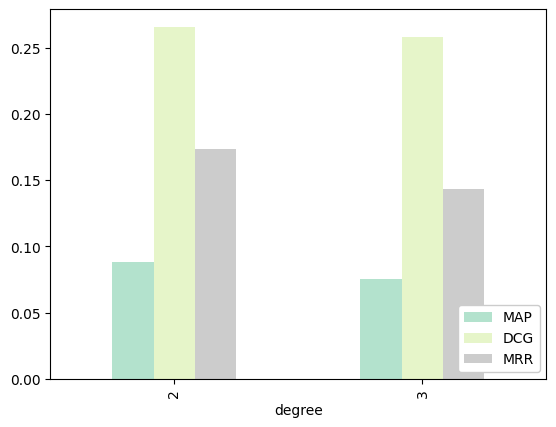

In [14]:
ax = df.groupby(["degree"])[["MAP", "DCG", "MRR"]].mean().plot.bar(cmap="Pastel2")
ax.legend(loc='lower right', framealpha=1)
fig = ax.get_figure()
fig.savefig('degree-plot.png', dpi=300)

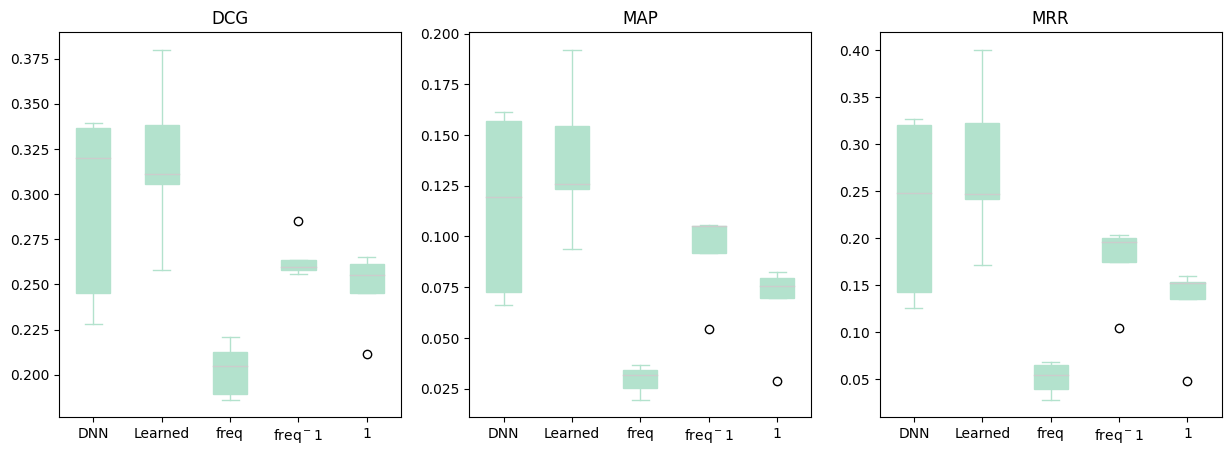

In [15]:
axs = df[df.degree == 2].plot.box(column=["MAP", "DCG", "MRR"], cmap="Pastel2", by="model", figsize=(15, 5), patch_artist=True)

for ax in axs:
  ax.set_xticklabels(["DNN", "Learned", "freq", "freq$^-1$", 1])


In [16]:
print(df.groupby("model")[["MAP", "DCG", "MRR"]].std().to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
 & MAP & DCG & MRR \\
model &  &  &  \\
\midrule
dnn & 0.06 & 0.07 & 0.13 \\
fit & 0.06 & 0.07 & 0.14 \\
frequency & 0.01 & 0.02 & 0.02 \\
inverse-frequency & 0.03 & 0.03 & 0.06 \\
uniform & 0.03 & 0.03 & 0.06 \\
\bottomrule
\end{tabular}



In [17]:
columns = [
  'http://www.w3.org/2006/time#hasEnd',
  'http://w3id.org/polifonia/ontology/meetups-ontology#hasEvidenceText',
  'http://w3id.org/polifonia/ontology/meetups-ontology#hasConfidence',
  'http://www.w3.org/2000/01/rdf-schema#seeAlso',
  'http://w3id.org/polifonia/ontology/meetups-ontology#hasDBPediaEntity',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
  'http://www.w3.org/2000/01/rdf-schema#label',
  'http://w3id.org/polifonia/ontology/meetups-ontology#hasAPurpose',
  'MRR',
  'MAP', 
  'DCG'
]

In [18]:
df[columns].corr().loc[["MRR", "MAP", "DCG"], columns[:-3]]

,http://www.w3.org/2006/time#hasEnd,http://w3id.org/polifonia/ontology/meetups-ontology#hasEvidenceText,http://w3id.org/polifonia/ontology/meetups-ontology#hasConfidence,http://www.w3.org/2000/01/rdf-schema#seeAlso,http://w3id.org/polifonia/ontology/meetups-ontology#hasDBPediaEntity,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2000/01/rdf-schema#label,http://w3id.org/polifonia/ontology/meetups-ontology#hasAPurpose
MRR,-0.095264,-0.024312,-0.086510,0.022697,0.143027,0.230964,-0.126715,-0.086183
MAP,-0.088027,-0.015963,-0.079511,0.031835,0.154533,0.238300,-0.120157,-0.079062
DCG,-0.102644,-0.032007,-0.094710,0.015728,0.127898,0.222183,-0.133858,-0.094028


In [19]:
import numpy as np
small_df = df[(df.model == "fit") & (df.degree == 2)].groupby(["degree", "model"]).agg(["median", "mean", "min", "max"])[columns[:-3]].T.reset_index()
small_df.columns = small_df.columns.get_level_values(0)
small_df = small_df.pivot(columns="level_1", index="level_0", values=2)

In [20]:
print(small_df.to_latex())

\begin{tabular}{lllll}
\toprule
level_1 & max & mean & median & min \\
level_0 &  &  &  &  \\
\midrule
http://w3id.org/polifonia/ontology/meetups-ontology#hasAPurpose & 2.160862 & 2.127842 & 2.124686 & 2.083878 \\
http://w3id.org/polifonia/ontology/meetups-ontology#hasConfidence & 2.160862 & 2.129237 & 2.131659 & 2.083878 \\
http://w3id.org/polifonia/ontology/meetups-ontology#hasDBPediaEntity & 2.173279 & 2.142193 & 2.140544 & 2.102805 \\
http://w3id.org/polifonia/ontology/meetups-ontology#hasEvidenceText & 2.160862 & 2.129340 & 2.124686 & 2.091365 \\
http://www.w3.org/1999/02/22-rdf-syntax-ns#type & 2.160862 & 2.132189 & 2.128404 & 2.093433 \\
http://www.w3.org/2000/01/rdf-schema#label & 2.173279 & 2.142193 & 2.140544 & 2.102805 \\
http://www.w3.org/2000/01/rdf-schema#seeAlso & 2.173279 & 2.142193 & 2.140544 & 2.102805 \\
http://www.w3.org/2006/time#hasEnd & 2.173279 & 2.142193 & 2.140544 & 2.102805 \\
\bottomrule
\end{tabular}

